## 基于mindspore实现二维线性回归

本实验将实现基于mindspore的二维线性回归，包括人造数据集、模型、损失函数和小批量随机梯度下降优化器。

### 1、实验目的
- 掌握如何使用MindSpore实现二维线性回归模型。
- 了解如何使用MindSpore定义小批量随机梯度下降优化器。
- 了解如何使用MindSpore计算梯度。


### 2、整体模型介绍
- 二维线性回归原理

在机器学习领域，线性回归模型记为：
$$y=w_0x_0+w_1x_1+\cdots+w_nx_n+b=[w_0 w_1 w_2 \cdots w_n][x_0 x_1 x_2 \cdots x_n]^T+b$$
可以统一形式为：
$$y=\sum_{i=0}^{n}w_ix_i+b=w^Tx+b$$


并且我们定义损失函数来度量模型一次预测的好坏，即预测值$\widehat y$和真实值y的误差，线性损失函数一般取$L=\frac{1}{2}(y-\widehat y)^2$，平方损失函数的几何意义是欧氏距离。

之后我们便可进行模型训练，采用梯度下降方法求模型参数w，使损失函数最小。

梯度下降法顺着当前点梯度反方向，按规定步长$\alpha$进行迭代搜索，对第i个模型参数进行如下更新：
$$w_{i+1}=w_i-\alpha \frac{\partial L(w)}{\partial (w_i)}$$
因为
$$\frac{\partial L(w)}{\partial (w_i)}=-\sum_{j=0}^{m}[y^{(j)}-\sum_{i=0}^{n}w_i x_i^{(j)}-b]*x_i^{(j)}$$
所以
$$w_{i+1}=w_i+\alpha [\sum_{j=0}^{m}(y^{(j)}-\sum_{i=0}^{n}w_i x_i^{(j)}-b)*x_i^{(j)}]$$
对每个模型参数迭代训练直到收敛即可。因此二维线性回归的自变量为两个，模型便为：
$$y=w_0x_0+w_1x_1+b=w^Tx+b$$
我们可定义二维线性回归模型Net、小批量随机梯度下降模型MBGD、整合整体运算过程的模型Trian实现二维线性回归。

- 定义一个二维线性回归模型Net，Net输入为样本$X$和对应的真实值y，根据公式$y=Xw+b=w_0x_0+w_1x_1+b$
计算出预测值$\widehat y$，然后根据$\widehat y$和y计算出均方损失并返回。
- 定义小批量随机梯度下降模型MBGD，输入计算好的梯度，完成权重更新操作。在每一步中，MBGD使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度，朝着减少损失的方向更新参数。
- 定义模型Train整合整个训练过程，完成预测值与真实值之间的损失计算、梯度计算、Net权重更新。

通过定义以上三个模型即可实现二维线性回归模型的训练。

### 3 实验环境
在动手进行实践之前，需要注意以下几点：
* 确保实验环境正确安装，包括安装MindSpore。安装过程：首先登录[MindSpore官网安装页面](https://www.mindspore.cn/install)，根据安装指南下载安装包及查询相关文档。同时，官网环境安装也可以按下表说明找到对应环境搭建文档链接，根据环境搭建手册配置对应的实验环境。
* 推荐使用交互式的计算环境Jupyter Notebook，其交互性强，易于可视化，适合频繁修改的数据分析实验环境。
* 实验也可以在华为云一站式的AI开发平台ModelArts上完成。
* 推荐实验环境：MindSpore版本=2.0；Python环境=3.7


|  硬件平台 |  操作系统  | 软件环境 | 开发环境 | 环境搭建链接 |
| :-----:| :----: | :----: |:----:   |:----:   |
| CPU | Windows-x64 | MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.1节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| GPU CUDA 10.1|Linux-x86_64| MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.2节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| Ascend 910  | Linux-x86_64| MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第四章](./MindSpore环境搭建实验手册.docx)|


### 4、数据处理
#### 4.1 数据准备
为了简单起见，我们将根据带有噪声的线性模型构造一个人造数据集。任务是使用这个有限样本的数据集来恢复这个模型的参数。我们需要生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。 合成的数据集是一个矩阵$X∈R^{(1000×2)}$。我们使用线性模型参数$w =[2,-3.4]^T$、b=3.2和噪声项$\epsilon$生成数据集及其标签：
$y=Xw+b+\epsilon=w_0x_0+w_1x_1+b+\epsilon$

$\epsilon$可以视为模型预测和标签之间的观测误差，我们假设ϵ服从均值为0、标准差为0.01的正态分布。


random库实现了各种分布的伪随机数生成器；dtype是MindSpore数据类型的对象；mindspore.numpy工具包提供了一系列类NumPy接口，用户可以使用类NumPy语法在MindSpore上进行模型的搭建；mindspore.ops提供对神经网络层的各种操作；pyplot是常用的绘图模块，能很方便让用户绘制 2D 图表；mindspore中的Tensor是张量，可放在gpu上加速。

In [14]:
import random
import mindspore
from mindspore import dtype as mstype
import mindspore.numpy as mnp
import mindspore.ops as ops
from matplotlib import pyplot as plt
from mindspore import Tensor
import sys
sys.path.append('..')

In [15]:
def synthetic_data(w, b, num_examples):  
    print((num_examples, len(w)))
    # 生成X
    X = ops.normal((num_examples, len(w)), Tensor(0, mstype.int32), Tensor(1, mstype.int32)) 
    # y = Xw + b
    y = ops.matmul(X, w) + b                               
    # y = Xw + b + 噪声。
    y += ops.normal(y.shape, Tensor(0, mstype.int32), Tensor(0.01, mstype.float32))          
    return X, y.reshape((-1, 1))

mindspore.set_seed(1)
true_w = Tensor([2, -3.4], mstype.float32)
true_b = 4.2
# 人造数据
features, labels = synthetic_data(true_w, true_b, 1000)                                                    

(1000, 2)


#### 4.2 数据加载
数据features中的每一行都包含一个二维数据样本，真实值labels中的每一行都包含一维标签值（一个标量）

In [16]:
print('features:', features[0:4],'\nlabel:', labels[0:4])

features: [[ 0.15606569  0.30639967]
 [-0.5680398  -0.42438623]
 [-0.8062886  -0.20454668]
 [-1.2000442  -0.42873764]] 
label: [[3.487765 ]
 [4.4927335]
 [3.2986383]
 [3.2585537]]


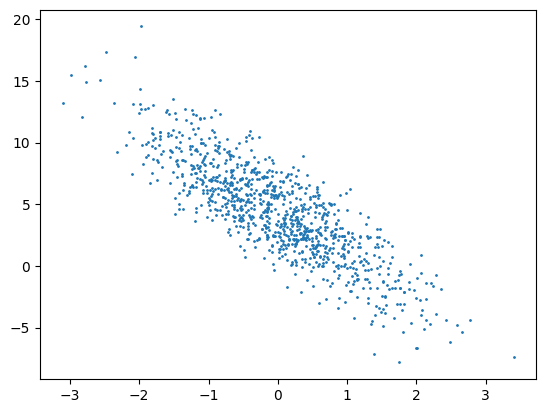

In [17]:
# 画出第二个特征与真实值的散点图
plt.scatter(features[:, (1)].asnumpy(), labels.asnumpy(), 1); 
plt.show()

因为训练模型时要对数据集遍历，每次迭代抽取一批样本来更新模型。因此我们需要定义函数data_iter(batch_size, features, labels)，用以打乱数据集中的样本并返回多批数据。

In [18]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 打乱indices
    random.shuffle(indices)                                     
    for i in range(0, num_examples, batch_size):
        # 最后一批数据大小可能小于batch_size
        batch_indices = Tensor(
            indices[i: min(i + batch_size, num_examples)])      
        yield features[batch_indices], labels[batch_indices]

        
batch_size = 10
# 一个batch的数据展示
for X, y in data_iter(batch_size, features, labels):            
    print(X, '\n', y)
    break

[[-0.70795256  0.00585518]
 [ 0.5678514   0.18228188]
 [ 1.0641294   0.58768374]
 [ 0.627971   -0.938906  ]
 [ 1.0876857   0.15488459]
 [-0.09322714 -1.1464157 ]
 [ 1.2824048   0.20530048]
 [-0.5124709  -1.4447352 ]
 [ 0.04773738 -0.6046286 ]
 [ 1.3733644  -1.2186161 ]] 
 [[ 2.7527766]
 [ 4.7167115]
 [ 4.3266964]
 [ 8.653568 ]
 [ 5.832618 ]
 [ 7.9077516]
 [ 6.045809 ]
 [ 8.101238 ]
 [ 6.3418064]
 [11.102836 ]]


### 5、模型构建
- 定义小批量随机梯度下降

在我们开始用小批量随机梯度下降优化我们的模型参数之前，需要说明一下MindSpore的设计理念。MindSpore的静态图思路是将整个模型视作一个完整的计算图，即模型、Loss、优化器均需要作为计算图的一部分，因此需要模型Train来整合。这与Pytorch的使用习惯有些不符。

mindspore.nn用于构建神经网络中的预定义构建块或计算单元；Parameter 是 Tensor 的子类，当它们被绑定为Cell的属性时，会自动添加到其参数列表中，并且可以通过Cell的某些方法获取；mindspore.common.initializer用于初始化神经元参数。

In [19]:
import mindspore.nn as nn
from mindspore import Parameter
from mindspore.common.initializer import initializer, Zero, Normal

def linreg(x, w, b):
    # y = Xw+b
    return ops.matmul(x, w) + b                         

In [20]:
def squared_loss(y_hat, y):  
    # 均方损失
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2   

In [21]:
class MBGD(nn.Cell):
    def __init__(self, lr, batch_size, params):
        super().__init__()
        self.lr = lr
        self.batch_size = batch_size
        self.params = params
        
    def construct(self, grads):
        for idx in range(len(self.params)):
            # 这里用到了一个assign算子，因为静态图里无法直接使用x = x + y来更新权重，采用assign算子实际上是为了能够给权重赋值，覆盖旧的权重数据
            ops.assign(self.params[idx], self.params[idx] - self.lr * grads[idx] / self.batch_size)
        return True

输入为计算好的反向梯度，用以更新模型Net的权重。
- 定义模型Net

定义模型class Net(nn.Cell)，这里需要用到nn.Cell，因为只有这样才能够使编译器识别编译为计算图。Net输入为X样本、y真实值，计算出预测值$\widehat y$后，用$\widehat y$和y计算损失并返回。

In [22]:
class Net(nn.Cell):
    def __init__(self):
        super().__init__()
        self.w = Parameter(initializer(Normal(0.01, 0), (2, 1), mstype.float32))
        self.b = Parameter(initializer(Zero(), 1, mstype.float32))
        
    def construct(self, x, y):
        # y_hat = Xw+b
        y_hat = linreg(x, self.w, self.b)  
        # 均方损失
        loss = squared_loss(y_hat, y)      
        return loss

### 6、模型训练
训练过程包括三步：
- 计算正向结果
- 计算反向梯度
- 更新权重

因此定义class Train(nn.Cell)将Net、优化器、计算反向梯度整合，作为完整的计算图，因此也要继承nn.Cell。计算反向梯度可以用ops.GradOpertion()。

In [23]:
class Train(nn.Cell):
    def __init__(self, network, optimizer):
        super().__init__()
        self.network = network
        self.optimizer = optimizer
        self.grad = ops.GradOperation(get_by_list=True)
        
    def construct(self, x, y):
        # 计算得到均方损失
        loss = self.network(x, y)            
        # 计算梯度
        grads = self.grad(self.network, self.optimizer.params)(x, y)  
        loss = ops.depend(loss, self.optimizer(grads))
        return loss

In [24]:
lr = 0.03
num_epochs = 3
# Net用于计算正向结果
net = Net()                                       
# optim用于更新权重
optim = MBGD(lr, batch_size, net.trainable_params())                              
# train用于计算反向梯度并整合
train = Train(net, optim)                                                         
for epoch in range(num_epochs):
    # 每次返回一个batch_size的数据
    for x, y in data_iter(batch_size, features, labels):                          
        l = train(x, y)
    train_l = net(features, labels)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean().asnumpy()):f}')

epoch 1, loss 0.031071
epoch 2, loss 0.000109
epoch 3, loss 0.000051


### 7、模型预测
训练3个epoch后输出w和b的估计误差，比较真实参数和通过训练学到的参数来评估训练的成功程度。

In [25]:
train_l = net(features, labels)
print(f'epoch {epoch + 1}, loss {float(train_l.mean().asnumpy()):f}')

epoch 3, loss 0.000051


In [26]:
# w的真实值和训练值之差
print(f'w的估计误差: {true_w - net.trainable_params()[0].reshape(true_w.shape)}')  
# b的真实值和训练值之差
print(f'b的估计误差: {true_b - net.trainable_params()[1]}')                        

w的估计误差: [-6.3824654e-04  3.5285950e-05]
b的估计误差: [0.00018406]
